### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [2]:
def model(x_data, distr : pyro.distributions):
    #pyro.clear_param_store()
    theta_1 = pyro.sample( 'theta_1', distr )
    theta_2 = pyro.sample( 'theta_2', distr )
    #y = pyro.param( 'y', x_data*theta_1/(theta_2+x_data) )
    y_par =  x_data*theta_1/(theta_2+x_data)
    y = pyro.sample( 'y', dist.Normal( y_par, 1 ) )
    return y

y_data = torch.tensor( [0.053,0.060,0.112,0.105,0.099,0.122] )
x = torch.tensor( [28,55,110,138,225,375] )
conditioned_model = pyro.condition( model, data={'y': y_data} )
conditioned_model(x, dist.Exponential(1))

tensor([0.0530, 0.0600, 0.1120, 0.1050, 0.0990, 0.1220])

In [3]:
def run_mcmc(kernel, n_samples, warmup, n_chains, data, dist: torch.distributions.Distribution):
    mcmc = MCMC(kernel, num_samples=n_samples, warmup_steps=warmup, num_chains=n_chains) 
    mcmc.run(x_data=data, distr=dist)
    return mcmc

def plot_posterior_distr(mcmc):
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    
    for key in mcmc_samples.keys():
        print("expected ", key , " = ", mcmc_samples[key].mean().item())
        
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    for i, key in enumerate(mcmc_samples.keys()):
        sns.distplot(mcmc_samples[key], ax=ax[i])
        ax[i].set_title("P(" + key + " | y=obs )")
        ax[i].set_xlabel(xlabel=key)

def plot_chains(mcmc):
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    n_chains = mcmc.num_chains
    n_samples = mcmc.num_samples
    print("n_chains", n_chains, " n_samples", n_samples)
    
    fig, ax = plt.subplots(len( mcmc_samples ), n_chains, figsize=(12,5))
    plt.subplots_adjust(bottom=-0.5)
    for i, key in enumerate(mcmc_samples.keys()):
        for j, chain in enumerate(mcmc_samples[key]):
            sns.lineplot( x=range(n_samples), y=chain, ax=ax[i][j] )
            ax[i][j].set_title( key+" chain " + str( j + 1 ) )

In [6]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(1) )
print(mcmc.get_samples().keys())




dict_keys(['theta_1', 'theta_2'])


n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.28      0.23      0.23      0.00      0.61     74.36      1.04
   theta_2      0.95      0.89      0.64      0.00      2.16    157.93      1.05

Number of divergences: 0


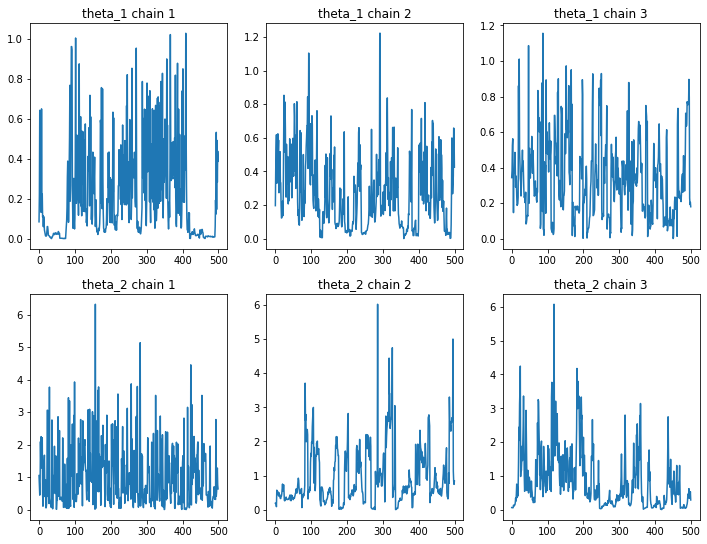

In [7]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  0.2792232632637024
expected  theta_2  =  0.9490628242492676


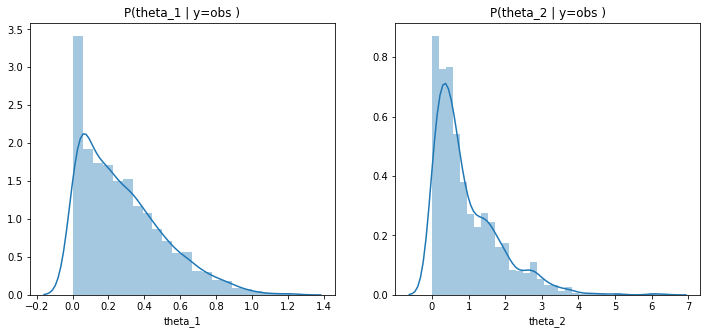

In [8]:
plot_posterior_distr(mcmc)

In [4]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Normal(0,1))

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.07      0.39      0.09     -0.57      0.64    129.15      1.01
   theta_2      0.22      0.94      0.25     -1.30      1.83     22.43      1.13

Number of divergences: 0


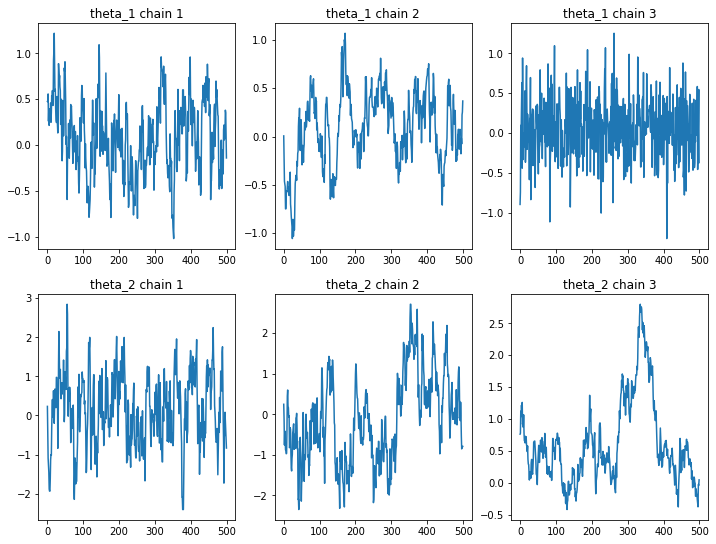

In [5]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  0.07440811395645142
expected  theta_2  =  0.2200564593076706


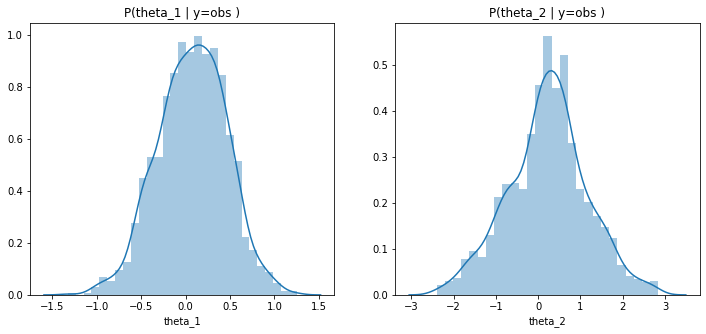

In [6]:
plot_posterior_distr(mcmc)

In [4]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(15) )

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.06      0.06      0.04      0.00      0.14    126.48      1.03
   theta_2      0.07      0.07      0.05      0.00      0.17    318.78      1.00

Number of divergences: 0


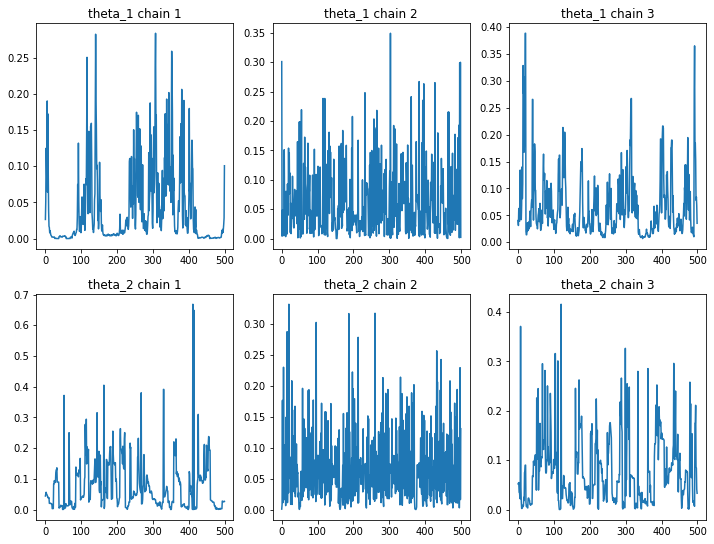

In [5]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  0.055915914475917816
expected  theta_2  =  0.07380720973014832


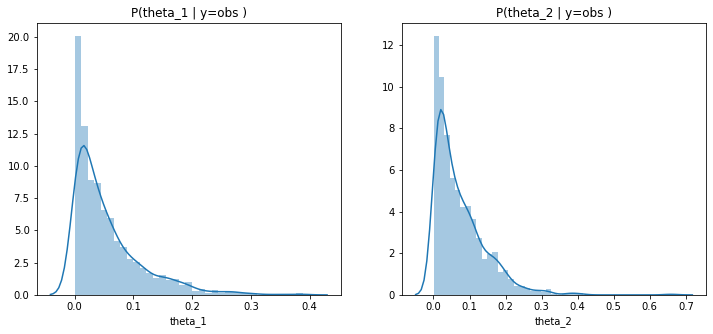

In [6]:
plot_posterior_distr(mcmc)

In [4]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Normal(0,100))

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.09      0.69      0.05     -1.04      1.32    142.10      1.02
   theta_2     66.52     73.76     63.73    -44.47    201.96     55.17      1.05

Number of divergences: 169


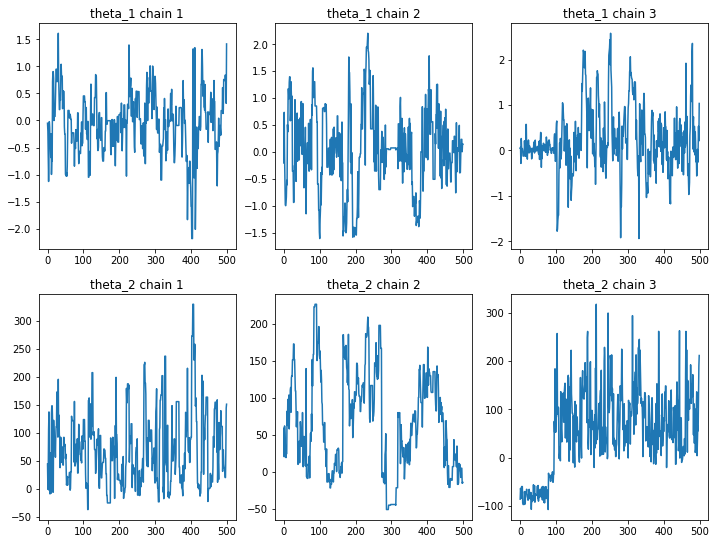

In [5]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  0.08812116831541061
expected  theta_2  =  66.51904296875


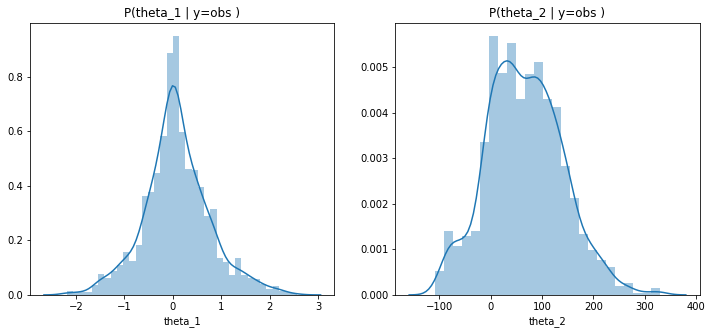

In [6]:
plot_posterior_distr(mcmc)

In [5]:
mcmc = run_mcmc( HMC(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(0.5) )

n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.34      0.24      0.29      0.01      0.69    316.30      1.01
   theta_2      1.96      2.04      1.27      0.00      4.53    256.56      1.00

Number of divergences: 0


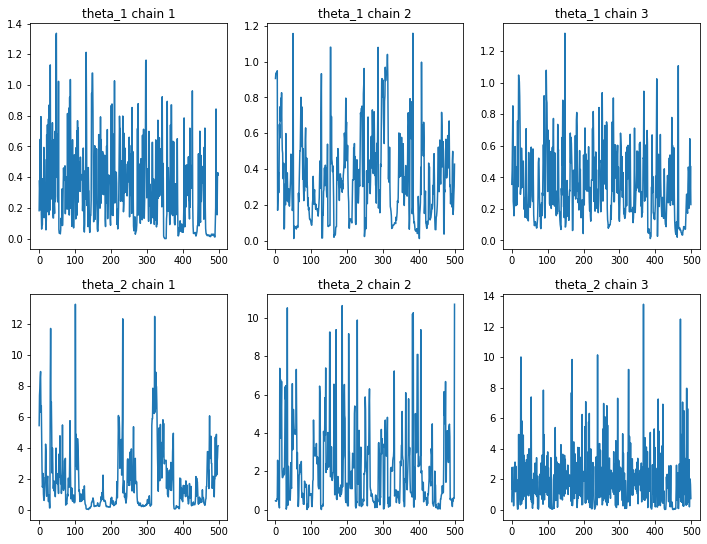

In [6]:
plot_chains(mcmc)
mcmc.summary()

expected  theta_1  =  0.3426488935947418
expected  theta_2  =  1.9625293016433716


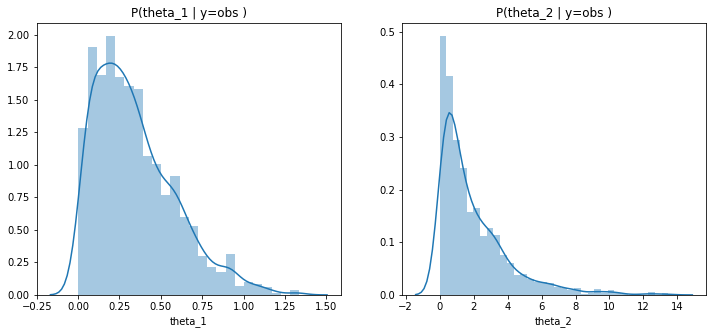

In [7]:
plot_posterior_distr(mcmc)




n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.33      0.25      0.28      0.00      0.68    749.98      1.00
   theta_2      2.01      2.04      1.37      0.00      4.61    768.43      1.00

Number of divergences: 0


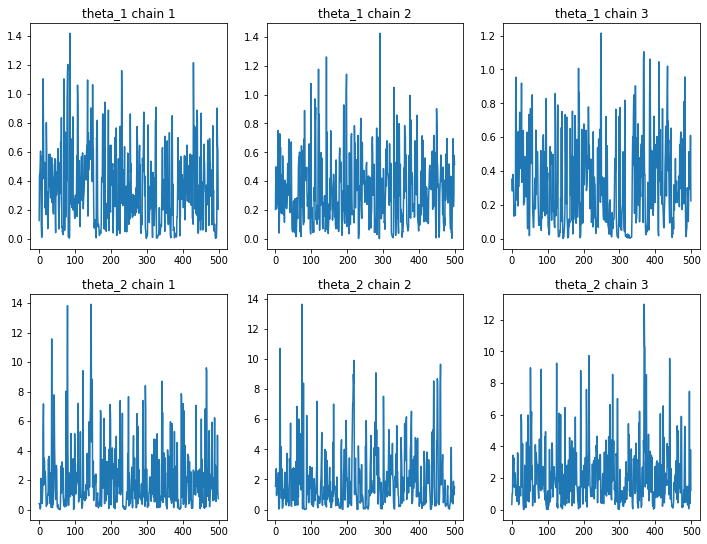

In [5]:
mcmc_nuts = run_mcmc( NUTS(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(0.5) )
plot_chains(mcmc_nuts)
mcmc_nuts.summary()

expected  theta_1  =  0.3307243287563324
expected  theta_2  =  2.0067429542541504


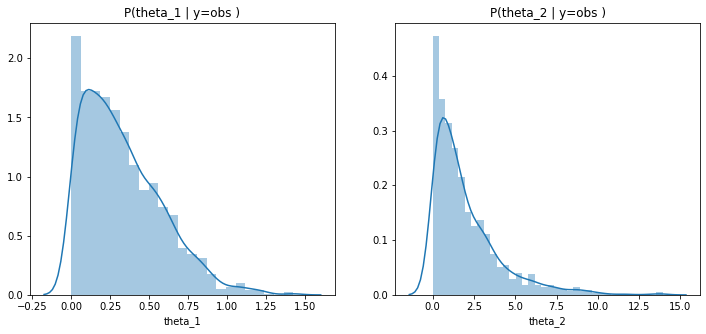

In [6]:
plot_posterior_distr(mcmc_nuts)




n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.31      0.23      0.26      0.00      0.63    728.72      1.00
   theta_2      1.02      0.94      0.73      0.00      2.28    880.45      1.00

Number of divergences: 0


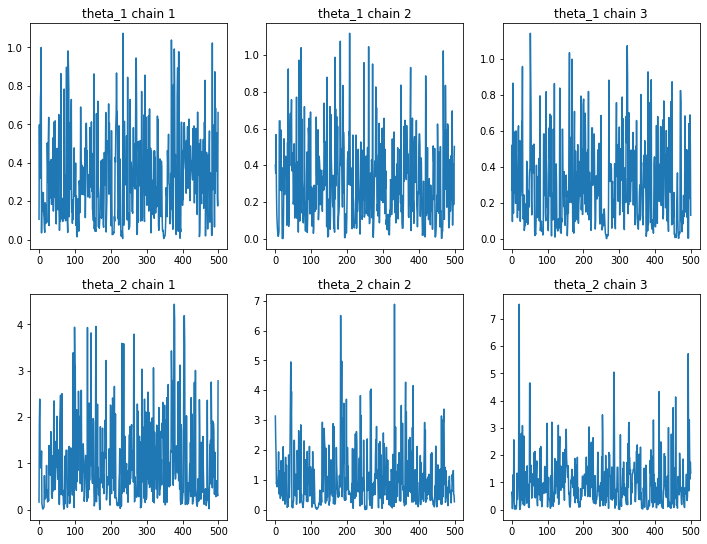

In [4]:
mcmc_nuts = run_mcmc( NUTS(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(1) )
plot_chains(mcmc_nuts)
mcmc_nuts.summary()

expected  theta_1  =  0.30945372581481934
expected  theta_2  =  1.0168870687484741


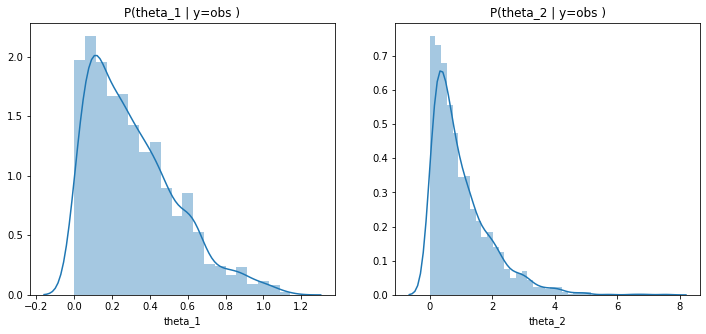

In [5]:
plot_posterior_distr(mcmc_nuts)




n_chains 3  n_samples 500

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.07      0.07      0.05      0.00      0.16    962.50      1.00
   theta_2      0.07      0.07      0.04      0.00      0.16    852.35      1.00

Number of divergences: 0


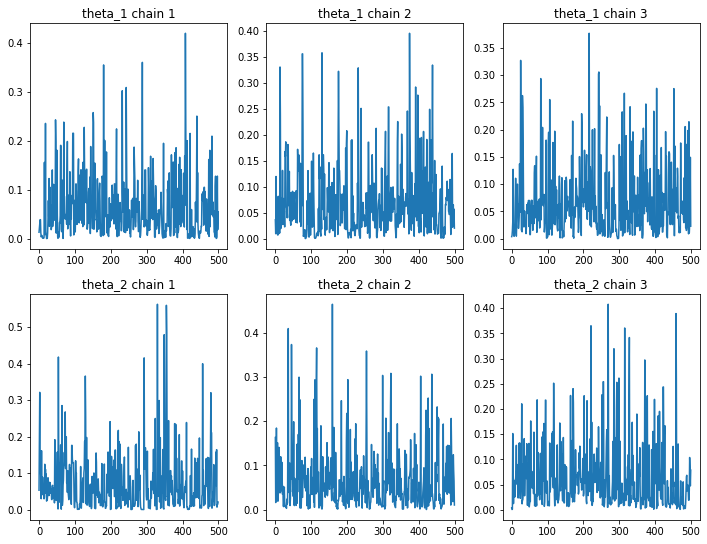

In [4]:
mcmc_nuts = run_mcmc( NUTS(model=conditioned_model), 500, 1000, 3, x, dist.Exponential(15) )
plot_chains(mcmc_nuts)
mcmc_nuts.summary()

expected  theta_1  =  0.06661627441644669
expected  theta_2  =  0.06702884286642075


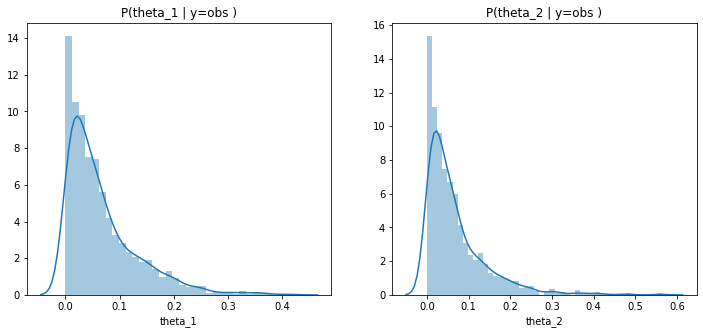

In [5]:
plot_posterior_distr(mcmc_nuts)

From the above tests it is possible to observe that the *exponential* distribution is more suitable for $\theta_1$ and $\theta_2$ than the *normal*, as the first result in a higher number of effective samples and a more stable $\hat{R}$ and we get also divergenses with the *normal*. Moreover, when $\theta_1, \: \theta_2 \sim Exp(15)$ MCMC is likely to produce an higher number of effective samples compared to $Exp(1)$ and $Exp(0.5)$.
NUTS behaves even better that HMC, with an higher $n_{eff}$ and a $\hat R$ stable to 1.

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

In [ ]:
def gibbs_sampler(iters, warmup, sigma2):
    x2 = pyro.sample( 'starting_x2', dist.Uniform(0,5) ) # (?) didn't know other way to initialise x2
    x1 = pyro.sample( 'x1_0', dist.Normal(0, sigma2+x2) )
    x1_temp = x1
    
    # (?) is this how a warup is supposed to be (?)
    for i in pyro.plate('warmup', warmup):
        x2 = pyro.sample( 'x2', dist.Normal(0, sigma2+x1) )
        x1 = pyro.sample( 'x1', dist.Normal(0, sigma2+x2) )
    
    x2_samples = []
    x1_samples = []
    for i in pyro.plate('samples', iters):
        x1_temp = x1_samples[i-1] if i != 0 else x1_temp
        x2_samples.append( pyro.sample('x2',dist.Normal(0, sigma2+x1_temp)) )
        x1_samples.append( pyro.sample('x1',dist.Normal(0, sigma2+x2_samples[i])) )
    
    return x1_samples, x2_samples

gibbs_sampler(500, 500, 1.0)